In [102]:
import pytesseract
from pytesseract import Output
from PIL import Image
import cv2
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import glob
import json
import pandas as pd
import sklearn
from sklearn.utils import shuffle
import seaborn as sn
import matplotlib.pyplot as plt
import re, string, unicodedata
import nltk
# import contractions
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer, TreebankWordTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
# Import stopwords with scikit-learn

In [3]:
# pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract'
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chrus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chrus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Chrus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# convert all images in dir to jpg
def to_format(ext, to_ext, inp, out, label):
    
    img_list = glob.glob('{dir}/*.{ext}'.format(dir=inp, ext=ext))
    print('total amount of files: ' + str(amount))
    for im, i in zip(img_list, range(len(img_list))):
        
        try:
            im = Image.open(im)
            im = im.convert('RGB')
            im.save('{output}/{label}{id}.{ext}'.format(output=out, label=label, id=i, ext=to_ext))
        
            print("Status: {perc}% done.".format(perc=str(((idx+1) / len(img_list)) * 100) + "%"))
        except Exception as e:
            print(e)
            pass
        
           
       # print("finished writing {percentage} percent...".format(percentage=math.ceil((100/len(labels))*(idx+1))))

In [4]:
to_format('png','jpg', './data/lieferbeleg/raw', './data/lieferbeleg/', 'lieferbeleg')

NameError: name 'amount' is not defined

In [5]:
def preprocess(im):
    """
    binarize image to improve accuracy
    """
    _ ,im = cv2.threshold(np.array(im),127,255,cv2.THRESH_BINARY)
    return Image.fromarray(im)

In [6]:

def extract_text(im):
    """
    extract text of given image
    :param im: image to extract text from
    """
    im = Image.open(im)
    im = preprocess(im)
    
    extracted = pytesseract.image_to_string(im, output_type=Output.DICT, lang='deu')
    return extracted

In [ ]:
def texts_to_list(input_dir, label):
    
    cap = 700
    res = []
    ext = "jpg"
    img_list = glob.glob('{dir}/*.{ext}'.format(dir=input_dir, ext=ext))
    print('amount files: {amount}'.format(amount = len(img_list)))
    for im, i in zip(img_list[:cap], range(len(img_list[:cap]))):
        
        extracted_text = extract_text(im)
        extracted_text['id'] = i +1
        extracted_text['label'] = label
        res.append(extracted_text)
        
        print("Status: {perc}% done.".format(perc=str(((i+1) / len(img_list[:cap])) * 100) + "%"))
   
    return res

In [ ]:
list_rb = texts_to_list('/Users/ct/local/rechnungsbeleg', label='invoice')

In [ ]:
list_lb = texts_to_list('/Users/ct/local/lieferschein', label='delivery')

In [ ]:
list_rg = texts_to_list('/Users/ct/local/regressforderung', label='regress')

In [267]:
with open('/Users/ct/develop/OCR/src/data/rechnungsbeleg/invoice_data.json', 'w') as fout:
    json.dump(list_rb, fout)
with open('/Users/ct/develop/OCR/src/data/lieferbeleg/delivery_data.json', 'w') as fout:
    json.dump(list_lb , fout)
with open('/Users/ct/develop/OCR/src/data/regress/regress_data.json', 'w') as fout:
    json.dump(list_rg, fout)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/ct/develop/OCR/src/data/rechnungsbeleg/invoice_data.json'

In [283]:
import pandas as pd

# read json into a dataframe
df_inv=pd.read_json("./data/rechnungsbeleg/invoice_data.json")
# df_del=pd.read_json("./data/lieferbeleg/delivery_data.json")
df_re=pd.read_json("./data/regress/regress_data.json")
# /Users/ct/local/collective
df = pd.concat([df_inv, df_re])
df = shuffle(df)

In [284]:
# normalization

stemmer = LancasterStemmer()
lemmatizer = WordNetLemmatizer()
p = inflect.engine()

def normalize(df):
    # remove special characters
    df['text'].apply(lambda x: re.sub("(\\W)+"," ",x))
    print('1. special')
    # remove punctuation
    df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x)) 
    print('1. punct')
    # tokenize 
    df['text'].apply(lambda x:nltk.word_tokenize(x))
    print('tokenize')
    # to lower case
    df['text'].apply(lambda x: [word.lower() for word in x])    
    print('lower case')

#    df['text'].apply(lambda x: [item for item in x if item not in new_stopwords_list])
#    print('filter')
    

    # stemming
    df['text'].apply(lambda x: [stemmer.stem(word) for word in x])  
    print('stemming')
    # lemmatizing
    df['text'].apply(lambda x: [lemmatizer.lemmatize(word, pos='v') for word in x])    
    print('lemma')

normalize(df)  

1. special
1. punct
tokenize
lower case
stemming
lemma


In [285]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=0)


In [286]:
def dummy(doc):
    return doc
# create a count vectorizer object disable preprocessing and tokenizing 
# the count vector counts all appearences of every word

#add words that aren't in the NLTK stopwords list
# filter stopwords
stop_words = set(stopwords.words("german"))
additional_stopwords = ['ok', 'a', 'e', 'm', 'de', 'd', 'hub', 'co', 'www',
                       'ag', 'i', 'x', '2016', '2015', '2014', 'gmbh', 'eda', 'uhr', 'homberg']

new_stopwords_list = stop_words.union(additional_stopwords)
token_pattern = token_pattern=r'\b[^\d\W]+\b'
count_vect = CountVectorizer(stop_words = new_stopwords_list, token_pattern=token_pattern)
from sklearn.feature_extraction import text 
docs = count_vect.fit_transform(X_train)


In [287]:
docs 

<1120x16767 sparse matrix of type '<class 'numpy.int64'>'
	with 109413 stored elements in Compressed Sparse Row format>

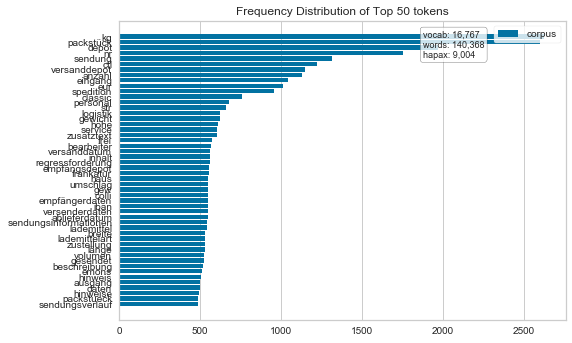

In [288]:
from yellowbrick.text import FreqDistVisualizer

features = count_vect.get_feature_names()
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof()

In [289]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(docs)
X_train_tfidf.shape

(1120, 16767)

In [290]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [291]:

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])
#count_vec = CountVectorizer()
#tfidf_transformer = TfidfTransformer()

#clf = MultinomialNB().fit(X_train_tfidf, y_train)


text_clf = text_clf.fit(X_train, y_train)

In [292]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

predicted = text_clf.predict(X_test)
predicted
np.mean(predicted == y_test)
from sklearn.metrics import classification_report
y_pred = text_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     invoice       0.99      1.00      0.99       143
     regress       1.00      0.99      0.99       137

    accuracy                           0.99       280
   macro avg       0.99      0.99      0.99       280
weighted avg       0.99      0.99      0.99       280



In [293]:
scores = cross_val_score(text_clf, X_test, y_test, cv=6)
predictions = cross_val_predict(text_clf, X_test, y_test, cv=6)
scores

array([0.9787234, 0.9787234, 0.9787234, 0.9787234, 1.       , 1.       ])

In [294]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions, labels=["invoice", "regress"])

array([[143,   0],
       [  4, 133]], dtype=int64)

In [295]:
scores = cross_val_score(text_clf, X_test, y_test, cv=6)
predictions = cross_val_predict(text_clf, X_test, y_test, cv=6)
scores

array([0.9787234, 0.9787234, 0.9787234, 0.9787234, 1.       , 1.       ])

In [296]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.99 (+/- 0.02)


In [297]:
# save the model to disk
import joblib

filename = 'text_clf.sav'
joblib.dump(text_clf, filename)


# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

0.9928571428571429
